In [160]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn import preprocessing
from timeit import default_timer as timer
from sklearn.externals import joblib

from sklearn.model_selection import RandomizedSearchCV

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)

train.isnull().values.any()
train.head(10)


(2400, 14)


,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793
5,6,227,40.0,0.5625,0.4375,0.000,9.8456,5.7176,14.1244,91.1235,91.3033,30.5730,0.2209,2.1633
6,7,206,80.0,0.0312,0.0938,0.875,10.1664,10.1664,10.1666,90.0009,90.0008,89.9987,0.0562,0.9854
7,8,12,20.0,0.5000,0.0000,0.500,12.1350,3.1533,6.2880,89.9997,105.1790,90.0001,0.2243,1.7179
8,9,206,80.0,0.5312,0.2188,0.250,9.4027,9.4023,9.4025,90.0025,90.0030,89.9978,0.2193,2.6257
9,10,194,80.0,0.4062,0.5938,0.000,6.2520,6.2520,23.7931,90.0172,89.9994,119.9997,0.1994,2.5187


In [161]:
vars = list(train)
#rint(len(vars))
#or i in vars[1:]:
    
#   print(i, sorted(train[i].unique()))
 #  print('----------------------------------')
  # print('')
    

In [162]:
#import seaborn as sns

#f, ax = plt.subplots(figsize=(10, 8))
#corr = train[vars[1:]].corr()
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#            square=True, ax=ax)
#plt.show()

In [163]:
target_fe = np.log1p(train.formation_energy_ev_natom)
target_be = np.log1p(train.bandgap_energy_ev)
#target_fe = (train.formation_energy_ev_natom)
#target_be = (train.bandgap_energy_ev)

train['number_of_total_atoms']=train['number_of_total_atoms'].astype(int)
test['number_of_total_atoms']=test['number_of_total_atoms'].astype(int)
del train['formation_energy_ev_natom'], train['bandgap_energy_ev'], train['id'], test['id']


In [164]:
train = pd.concat([train.drop(['spacegroup'], axis=1), 
                   pd.get_dummies(train['spacegroup'], prefix='SG')], axis=1)
test = pd.concat([test.drop(['spacegroup'], axis=1), 
                   pd.get_dummies(test['spacegroup'], prefix='SG')], axis=1)
train = pd.concat([train.drop(['number_of_total_atoms'], axis=1), 
                   pd.get_dummies(train['number_of_total_atoms'], prefix='NAT')], axis=1)
test = pd.concat([test.drop(['number_of_total_atoms'], axis=1), 
                   pd.get_dummies(test['number_of_total_atoms'], prefix='NAT')], axis=1)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train_fe, y_test_fe = train_test_split(train, target_fe, test_size=test_size, random_state=seed)
X_train, X_test, y_train_be, y_test_be = train_test_split(train, target_be, test_size=test_size, random_state=seed)

#X_train = preprocessing.scale(X_train)
#X_test  = preprocessing.scale(X_test)


In [105]:

#list(test)
#print(1/np.sqrt(len(train)))
#search for best model 
model=XGBRegressor()
search_params = {
    'max_depth':list(range(1,10,1)),
    'n_estimators':list(range(10,500,10)),
    'gamma':list(np.arange(0.,1,.05)),
    'min_child_weight':list(np.arange(0.1,1,.1)),
    'colsample_bytree':list(np.arange(0.1,1,.05))
}
search = RandomizedSearchCV(model, search_params, n_iter=10000)
search.fit(X_train, y_train_be)
#search.fit(X_train, y_train_fe)
print(search.best_params_)

{'max_depth': 2, 'gamma': 0.0, 'n_estimators': 400, 'colsample_bytree': 0.45000000000000007, 'min_child_weight': 0.59999999999999998}


In [165]:



# fit model no training data
#model = XGBClassifier(learning_rate=0.1,max_depth=6, subsample=1,min_child_weight=0.02,colsample_bytree=0.3)
model = XGBRegressor(gamma=0.0,max_depth=2,n_estimators=400,min_child_weight=0.59,colsample_bytree=0.45)
start = timer()
#model.fit(X_train, y_train_fe)
model.fit(X_train, y_train_be)
end = timer()


In [166]:
print('executation time : ', (end - start))  
print(model)
#filename = 'finalized_model_fe.sav'
filename = 'finalized_model_be.sav'
joblib.dump(model, filename)

executation time :  0.1457725530017342
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.45,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=0.59, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


['finalized_model_be.sav']

In [167]:
y_pred = model.predict(X_test)


In [168]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [169]:


#accuracy = rmsle(list(y_test_fe), list(y_pred))
accuracy = rmsle(list(y_test_be), list(y_pred))
print("rmsle: %.5f%%" % (accuracy))

MSE: 0.05186%


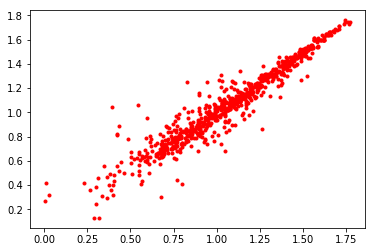

In [170]:
plt.plot(y_test_be, y_pred,'r.')
#plt.ylim((0,0.4))
#plt.xlim((0,0.4))
plt.show()


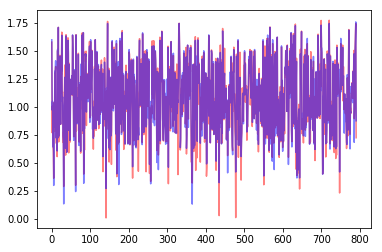

792 792


In [112]:
plt.plot(range(0,792),y_test_be, 'r', alpha=.5)
plt.plot(range(0,792),y_pred, 'b', alpha=.5)
plt.show()
print(len(y_test), len(y_pred))

In [113]:



loaded_model = joblib.load(filename)




In [114]:
loaded_model.predict(test)

array([ 0.94618309,  1.55314147,  1.50961936,  1.3777113 ,  0.93240917,
        1.72403264,  1.45189023,  1.14044619,  1.30504727,  1.38583553,
        1.05514669,  1.32796693,  0.69594216,  0.99929017,  0.66531706,
        1.49773073,  1.01465702,  1.22378969,  0.83562803,  0.88790751,
        1.03755426,  1.34162617,  1.02009869,  1.40356827,  1.29022908,
        0.65834022,  0.85834306,  1.04216576,  0.78695512,  1.07942724,
        0.73644108,  1.06653106,  0.9182691 ,  1.00833321,  0.65322101,
        0.58492666,  1.53419638,  0.89653438,  1.10489058,  1.46913791,
        1.59930539,  1.41402626,  1.59930539,  0.82621002,  0.50800323,
        1.58461058,  1.07133937,  1.05372918,  1.49353147,  0.80539024,
        1.13388467,  1.00185156,  0.93993664,  1.34654498,  1.36161804,
        0.39956909,  1.18904567,  1.26213133,  0.65733898,  1.34548688,
        0.42631516,  0.99502921,  1.03130102,  1.41982019,  0.73556775,
        1.35344338,  1.45189023,  1.12383199,  1.49451017,  1.00